In [1]:
import matplotlib.pyplot
import matplotlib.offsetbox
import numpy
import PIL.Image
import scipy.linalg
import scipy.spatial.distance

In [2]:
class PCA():
    def __init__(self, num_components: int):
        self.num_components = num_components
        return

    def _X_mean(self, X: numpy.ndarray) -> numpy.ndarray:
        X_mean = numpy.mean(a=X, axis=1, keepdims=True)   # mean of matrix X  [X, ]
        one_vec = numpy.ones(shape=(1, X.shape[1]))       # [1 x observations]
        X_mean_mat = X_mean@one_vec                       # features mean matrix   [# of features x # of samples]
        X_mean_center = X - X_mean_mat                    # mean-centered matrix X [# of features x # of samples]
        return X_mean_mat, X_mean_center

    def fit_transform(self, X: numpy.ndarray) -> tuple[numpy.ndarray, numpy.ndarray]:
        _, X_mean_center = self._X_mean(X=X)
        C = numpy.cov(m=X_mean_center, rowvar=True, bias=False)
        eigenvals, eigenvecs = scipy.linalg.eig(a=C)
        eigenval_indices = numpy.argsort(a=eigenvals)[::-1]
        eigenvals = eigenvals[eigenval_indices].real
        eigenvecs = eigenvecs[:, eigenval_indices].real
        Lambda = scipy.linalg.inv(a=numpy.diag(v=numpy.sqrt(eigenvals[:self.num_components])))
        U = eigenvecs[:, :self.num_components]
        W = Lambda@U.T
        Y = W@X_mean_center
        return W, Y

    def reconstruct(self, X: numpy.ndarray) -> numpy.ndarray:
        X_mean_mat, X_mean_center = self._X_mean(X=X)
        Z = self.U[:, :self.num_components].T@X_mean_center
        X_hat = self.U[:, :self.num_components]@Z+X_mean_mat
        return X_hat

In [3]:
class ICA():
    def __init__(self, num_components: int):
        self.num_components = num_components
        return

    def _tanh(self, x: numpy.ndarray) -> numpy.ndarray:
        return numpy.tanh(x)

    def fit_transform(self, X: numpy.ndarray, learning_rate: float=1e-4, tol: float=1e-5):
        N = X.shape[1]
        W = numpy.eye(N=self.num_components, dtype=numpy.float64)
        I = numpy.eye(N=self.num_components, dtype=numpy.float64)

        while True:
            Y = W@X
            dW = (N*I-2*self._tanh(x=Y)@Y.T)@W
            W += learning_rate*dW
            if numpy.abs(numpy.sum(a=dW, axis=(0,1))) <= tol:
                break
        return W, Y

In [4]:
class NMF():
    def __init__(self, num_components: int):
        self.num_components = num_components
        return

    def fit_transform(self, X: numpy.ndarray, max_iters: int=500, tol: float=1e-5) -> numpy.ndarray:
        num_features, num_samples = X.shape
        W = numpy.random.rand(num_features, self.num_components)
        H = numpy.random.rand(self.num_components, num_samples)

        for _ in range(max_iters):
            W_prev = W
            H_prev = H
            W = W * (X@H.T / (W@H@H.T + 1e-6))
            H = H * (W.T@X / (W.T@W@H + 1e-6))
            W_err = scipy.linalg.norm(a=(W-W_prev), ord=2)
            H_err = scipy.linalg.norm(a=(H-H_prev), ord=2)

            if W_err <= tol and H_err <= tol:
                break

        return W, H

In [5]:
# Reference: https://github.com/scipy/scipy/blob/main/scipy/sparse/csgraph/_shortest_path.pyx#L222
# Reference: https://gist.github.com/mosco/11178777

class Isomap():
    def __init__(self, num_nbrs: int, num_components: int):
        self.num_nbrs = num_nbrs
        self.num_components = num_components
        return

    def fit_transform(self, X: numpy.ndarray) -> numpy.ndarray:
        num_samples = X.shape[1]
        inf = 99999

        pairwise_dists = scipy.spatial.distance.cdist(XA=X.T, XB=X.T, metric="euclidean")
        pairwise_dists_sorted = numpy.argsort(a=pairwise_dists, axis=1)[:, 1:self.num_nbrs+1]
        dist_mat = numpy.zeros(shape=(num_samples, num_samples))
        for i, k in enumerate(pairwise_dists_sorted):
            dist_mat[i, k] = pairwise_dists[i, k]
        dist_mat[dist_mat == 0] = inf
        dist_mat.flat[::num_samples+1] = 0

        for i in range(num_samples):
            for j in range(i+1, num_samples):
                if dist_mat[j, i] <= dist_mat[i, j]:
                    dist_mat[i, j] = dist_mat[j, i]
                else:
                    dist_mat[j, i] = dist_mat[i, j]
        for k in range(num_samples):
            dist_mat = numpy.minimum(dist_mat, dist_mat[numpy.newaxis, k, :]+dist_mat[:, k, numpy.newaxis])

        dist_mat = -0.5*(dist_mat**2)
        one_vec = numpy.ones(shape=(num_samples, 1))
        row_mean_mat = one_vec@numpy.mean(a=dist_mat, axis=0, keepdims=True)
        col_mean_mat = numpy.mean(a=dist_mat, axis=1, keepdims=True)@one_vec.T
        dist_mat_mean = one_vec@numpy.mean(a=dist_mat, axis=(0, 1), keepdims=True)@one_vec.T
        dist_mat -= row_mean_mat
        dist_mat -= col_mean_mat
        dist_mat += dist_mat_mean

        eigenvals, eigenvecs = scipy.linalg.eig(a=dist_mat)
        eigenval_indices = numpy.argsort(a=eigenvals)[::-1]
        eigenvals = eigenvals[eigenval_indices].real
        eigenvecs = eigenvecs[:, eigenval_indices].real
        U = eigenvecs[:, :self.num_components].T
        return U


In [6]:
# Reference: https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points

def imScatter(ax, img, x, y, zoom):
    im = matplotlib.offsetbox.OffsetImage(arr=img, zoom=zoom)
    x, y = numpy.atleast_1d(x, y)
    ab = matplotlib.offsetbox.AnnotationBbox(offsetbox=im, xy=(x, y), xycoords="data", frameon=False)
    ax.add_artist(ab)
    ax.update_datalim(numpy.column_stack(tup=[x, y]))
    ax.autoscale()
    return

### Problem 1. An audio features project

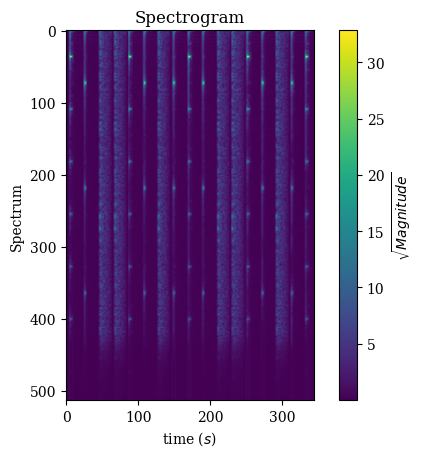

In [7]:
sample_rate, data = scipy.io.wavfile.read("vl1.wav")
data = data.astype(numpy.float64)

N = 1024            # window size
overlap = N*3//4    # overlap 768

# f: array of sample freq
# t: array of segment times
# Sxx: spectrogram [spectrum(freq) x segment times]
f, t, Sxx = scipy.signal.spectrogram(x=data, fs=sample_rate, window="hamming", nperseg=N, noverlap=overlap, mode="magnitude")
Sxx_sqrt = numpy.sqrt(Sxx)

matplotlib.pyplot.rc('font', family='serif')

matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(X=Sxx_sqrt)
matplotlib.pyplot.colorbar(label=r"$\sqrt{Magnitude}$")
matplotlib.pyplot.title(r"Spectrogram")
matplotlib.pyplot.xlabel(r"time ($s$)")
matplotlib.pyplot.ylabel(r"Spectrum")
matplotlib.pyplot.grid(visible=False)

##### PCA

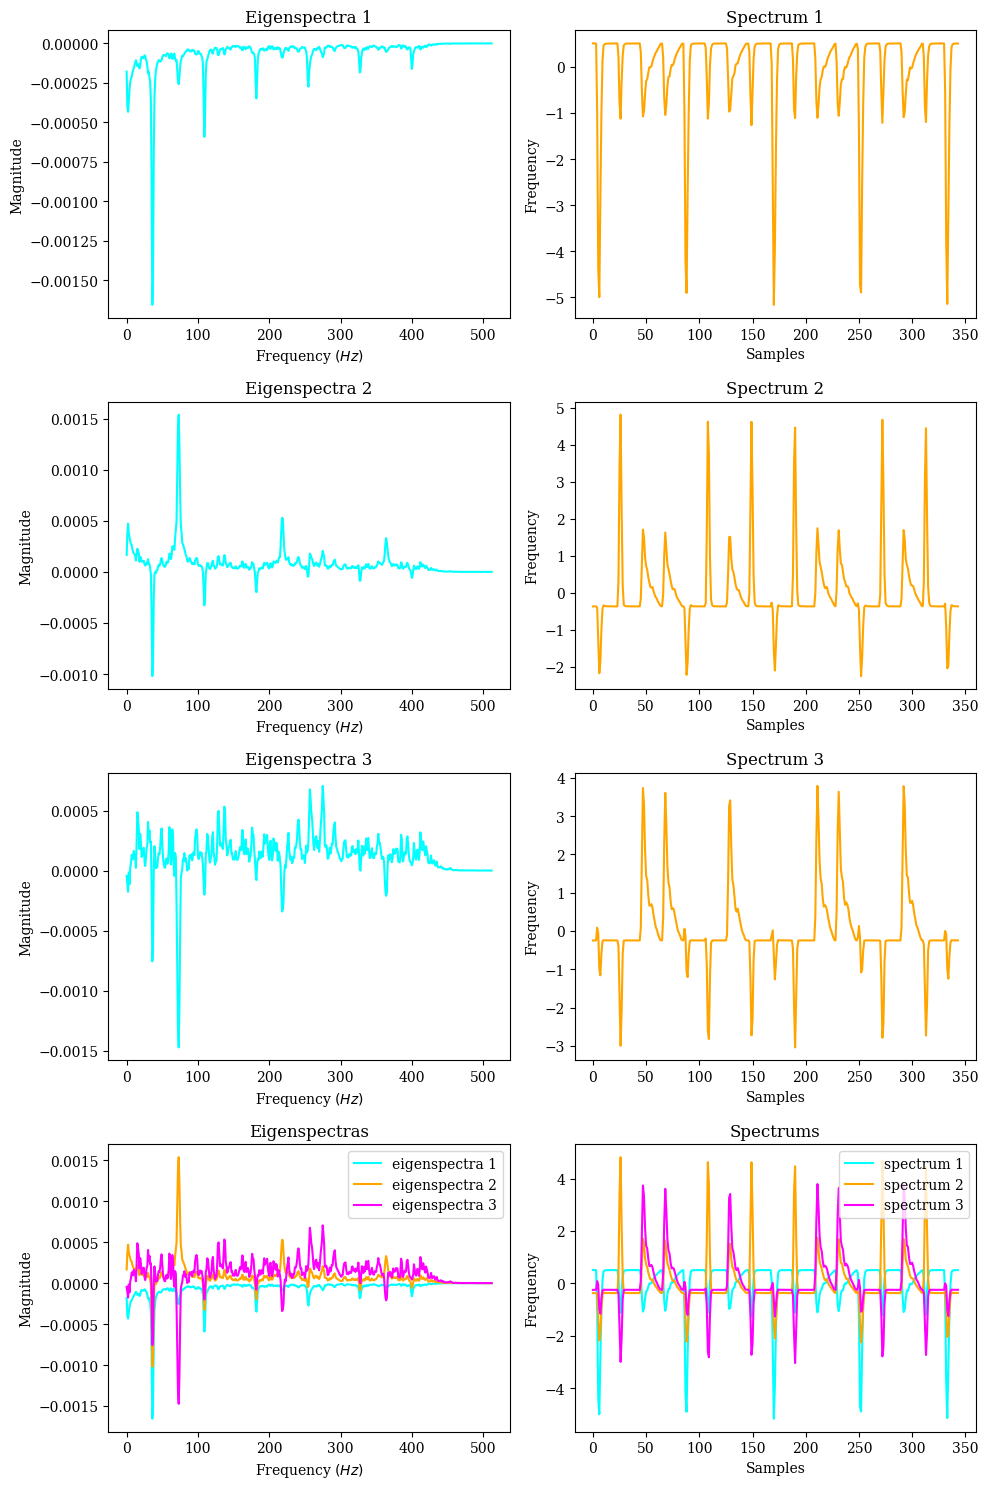

In [8]:
num_components = 3

pca = PCA(num_components=num_components)
W_pca, Y_pca = pca.fit_transform(X=Sxx)

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(4, 2, figsize=(10, 15))
labels_0 = ["eigenspectra 1", "eigenspectra 2", "eigenspectra 3"]
labels_1 = ["spectrum 1", "spectrum 2", "spectrum 3"]
colors = ["cyan", "orange", "magenta"]

for i in range(num_components+1):
    if i == num_components:
        for k in range(num_components):
            axs[i, 0].plot(W_pca[k], label=labels_0[k], color=colors[k])
        axs[i, 0].set_title(rf"Eigenspectras")
        axs[i, 0].set_xlabel(r"Frequency $(Hz)$")
        axs[i, 0].set_ylabel(r"Magnitude")
        axs[i, 0].legend(loc=1)
    else:
        axs[i, 0].plot(W_pca[i], color="cyan")
        axs[i, 0].set_title(rf"Eigenspectra {i+1}")
        axs[i, 0].set_xlabel(r"Frequency $(Hz)$")
        axs[i, 0].set_ylabel(r"Magnitude")
    
for j in range(num_components+1):
    if j == num_components:
        for k in range(num_components):
            axs[j, 1].plot(Y_pca[k], label=labels_1[k], color=colors[k])
        axs[j, 1].set_title(rf"Spectrums")
        axs[j, 1].set_xlabel(r"Samples")
        axs[j, 1].set_ylabel(r"Frequency")
        axs[j, 1].legend(loc=1)
    else:
        axs[j, 1].plot(Y_pca[j], color="orange")
        axs[j, 1].set_title(rf"Spectrum {j+1}")
        axs[j, 1].set_xlabel(r"Samples")
        axs[j, 1].set_ylabel(r"Frequency")

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

##### ICA

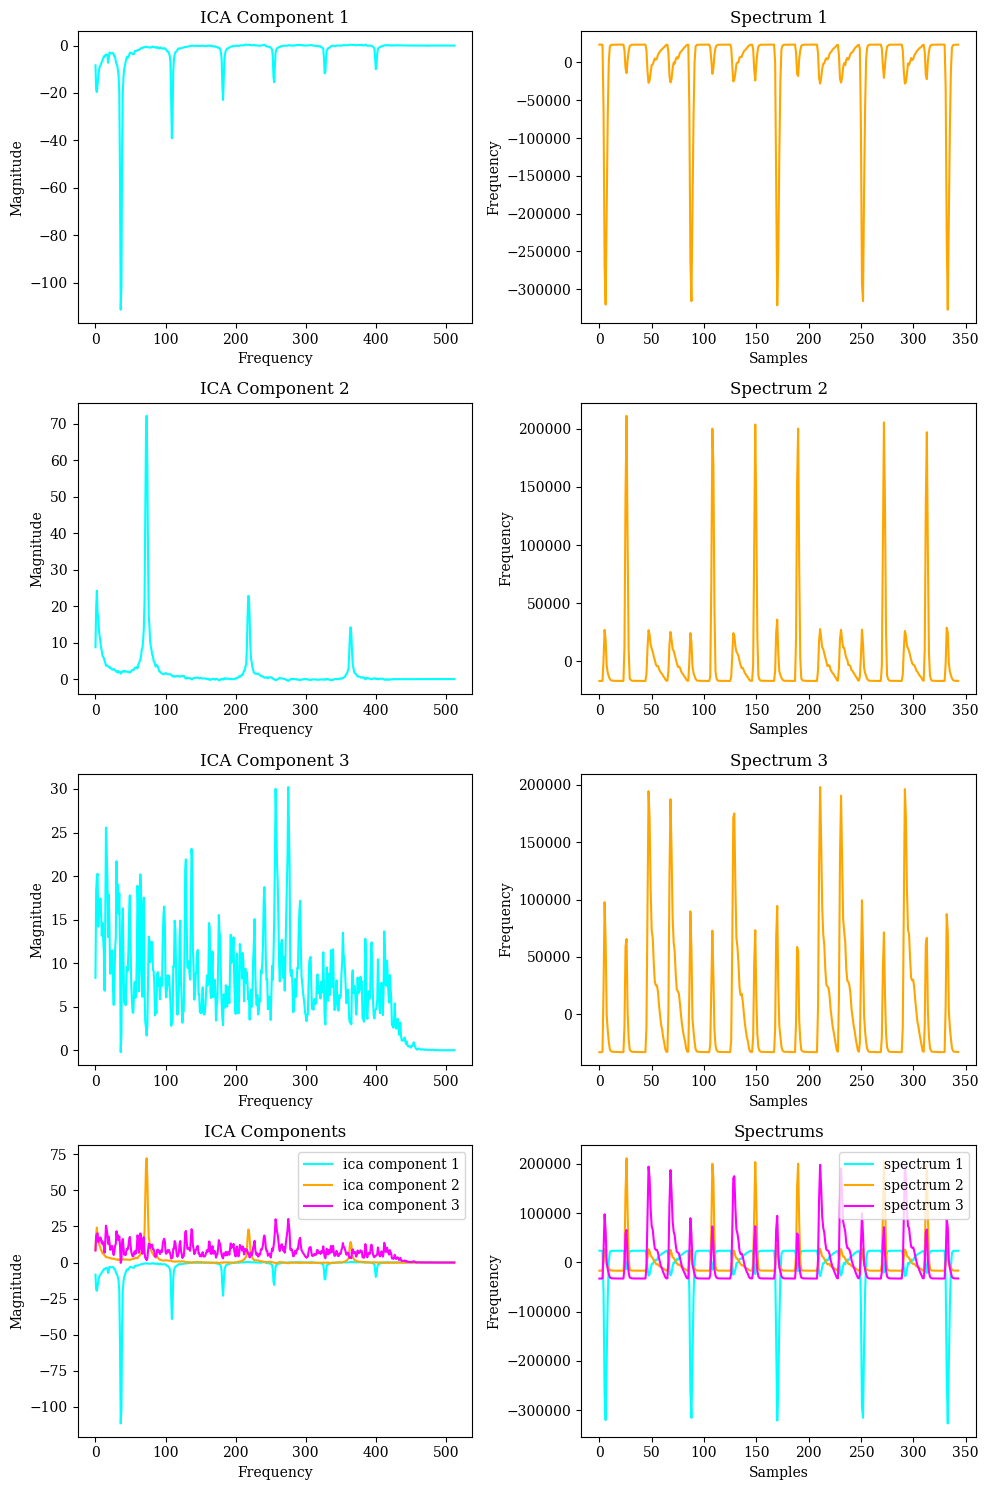

In [9]:
num_components = 3

ica = ICA(num_components=num_components)
W_ica, Y_ica = ica.fit_transform(X=Y_pca, learning_rate=1e-4, tol=1e-5)
mixing_mat = scipy.linalg.pinv(a=W_ica@W_pca)

Sxx_mean = numpy.mean(a=Sxx, axis=1, keepdims=True)
one_vec = numpy.ones(shape=(1, Sxx.shape[1]))
Sxx_mean_mat = Sxx_mean@one_vec
Sxx_mean_center = Sxx - Sxx_mean_mat
X_proj = mixing_mat.T@Sxx_mean_center

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(4, 2, figsize=(10, 15))
labels_0 = ["ica component 1", "ica component 2", "ica component 3"]
labels_1 = ["spectrum 1", "spectrum 2", "spectrum 3"]
colors = ["cyan", "orange", "magenta"]

for i in range(num_components+1):
    if i == num_components:
        for k in range(num_components):
            axs[i, 0].plot(mixing_mat[:, k], label=labels_0[k], color=colors[k])
        axs[i, 0].set_title(rf"ICA Components")
        axs[i, 0].set_xlabel(r"Frequency")
        axs[i, 0].set_ylabel(r"Magnitude")
        axs[i, 0].legend(loc=1)
    else:
        axs[i, 0].plot(mixing_mat[:, i], color="cyan")
        axs[i, 0].set_title(rf"ICA Component {i+1}")
        axs[i, 0].set_xlabel(r"Frequency")
        axs[i, 0].set_ylabel(r"Magnitude")
    
for j in range(num_components+1):
    if j == num_components:
        for k in range(num_components):
            axs[j, 1].plot(X_proj[k], label=labels_1[k], color=colors[k])
        axs[j, 1].set_title(rf"Spectrums")
        axs[j, 1].set_xlabel(r"Samples")
        axs[j, 1].set_ylabel(r"Frequency")
        axs[j, 1].legend(loc=1)
    else:
        axs[j, 1].plot(X_proj[j], color="orange")
        axs[j, 1].set_title(rf"Spectrum {j+1}")
        axs[j, 1].set_xlabel(r"Samples")
        axs[j, 1].set_ylabel(r"Frequency")

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

##### NMF

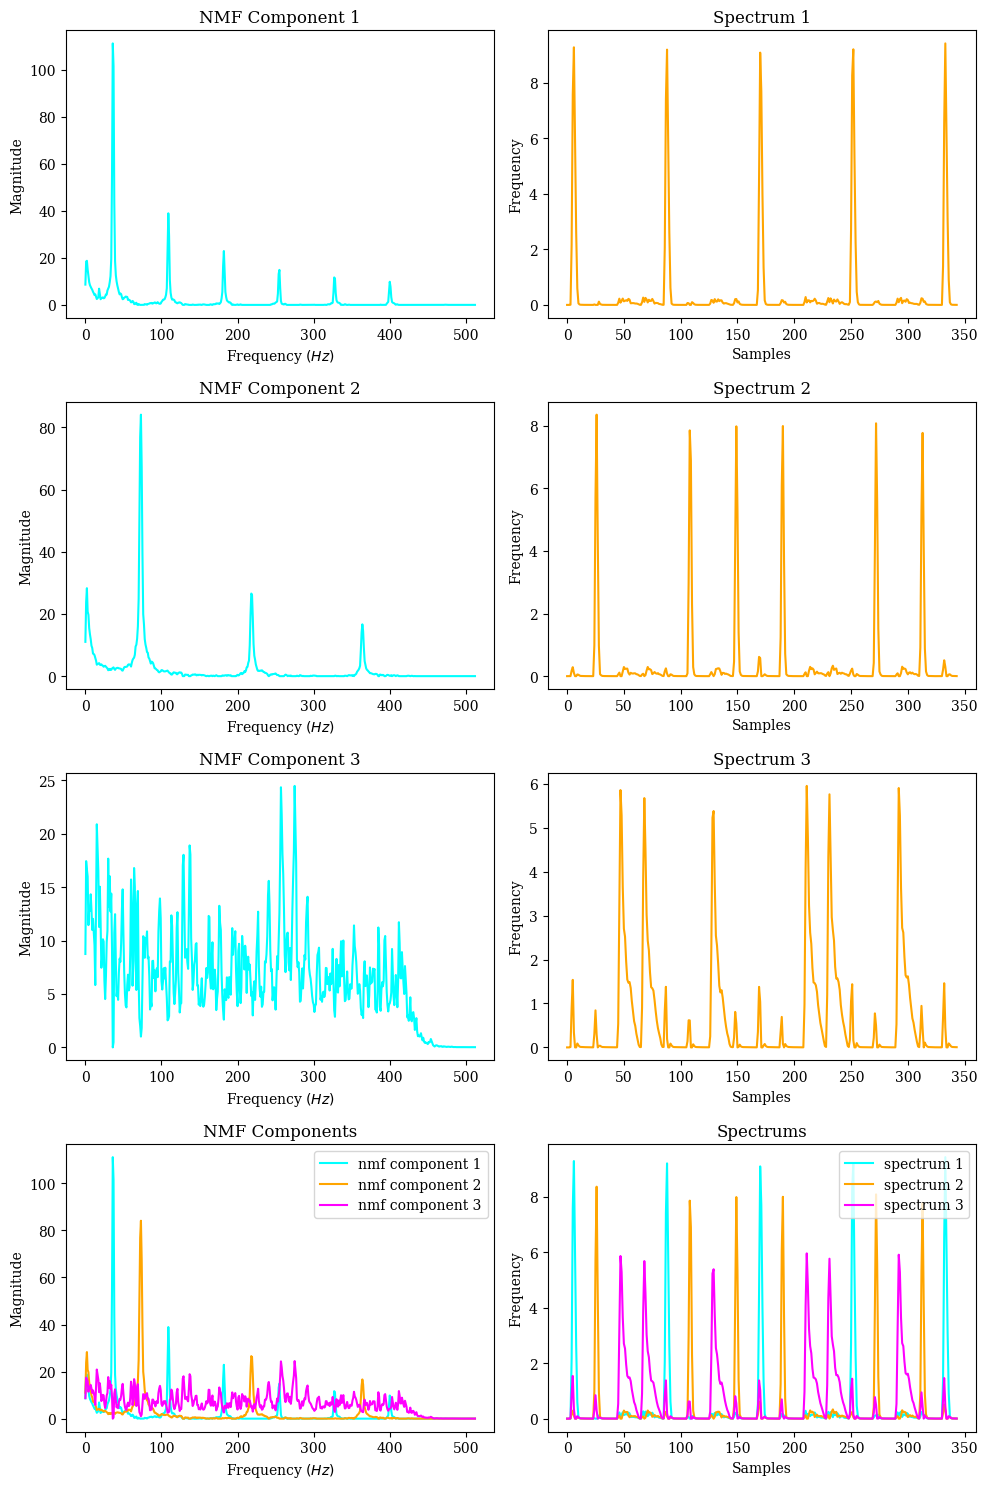

In [10]:
num_components=3

nmf = NMF(num_components=3)
W, H = nmf.fit_transform(X=Sxx)

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(4, 2, figsize=(10, 15))
labels_0 = ["nmf component 1", "nmf component 2", "nmf component 3"]
labels_1 = ["spectrum 1", "spectrum 2", "spectrum 3"]
colors = ["cyan", "orange", "magenta"]

for i in range(num_components+1):
    if i == num_components:
        for k in range(num_components):
            axs[i, 0].plot(W[:, k], label=labels_0[k], color=colors[k])
        axs[i, 0].set_title(rf"NMF Components")
        axs[i, 0].set_xlabel(r"Frequency $(Hz)$")
        axs[i, 0].set_ylabel(r"Magnitude")
        axs[i, 0].legend(loc=1)
    else:
        axs[i, 0].plot(W[:, i], color="cyan")
        axs[i, 0].set_title(rf"NMF Component {i+1}")
        axs[i, 0].set_xlabel(r"Frequency $(Hz)$")
        axs[i, 0].set_ylabel(r"Magnitude")
    
for j in range(num_components+1):
    if j == num_components:
        for k in range(num_components):
            axs[j, 1].plot(H[k], label=labels_1[k], color=colors[k])
        axs[j, 1].set_title(rf"Spectrums")
        axs[j, 1].set_xlabel(r"Samples")
        axs[j, 1].set_ylabel(r"Frequency")
        axs[j, 1].legend(loc=1)
    else:
        axs[j, 1].plot(H[j], color="orange")
        axs[j, 1].set_title(rf"Spectrum {j+1}")
        axs[j, 1].set_xlabel(r"Samples")
        axs[j, 1].set_ylabel(r"Frequency")

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

The spectrums reconstructed from the PCA weights (eigenspectras) are still somewhat correlated because PCA assumes gaussian distribution of the data. Compared to PCA weights, the spectrums reconstructed with $W_{ica}W_{pca}$ is better as it decorrelates the spectrum of the three instruments. The reason it's better is that ICA aims to separate information by transforming the input space into a maximally independent basis. Similarly to ICA, the reconstructed results with NMF is very similar and slightly better than ICA, it also successfully decorrelates the spectrum into three separate spectrums representing three different instruments. One advantage of NMF is that it decorrelates three spectrums more (almost no dependence) and its non-negativity. The spectrum of three instruments should have positive magnitude, but PCA and ICA fail to do that.

### Problem 2. Handwritten digit features

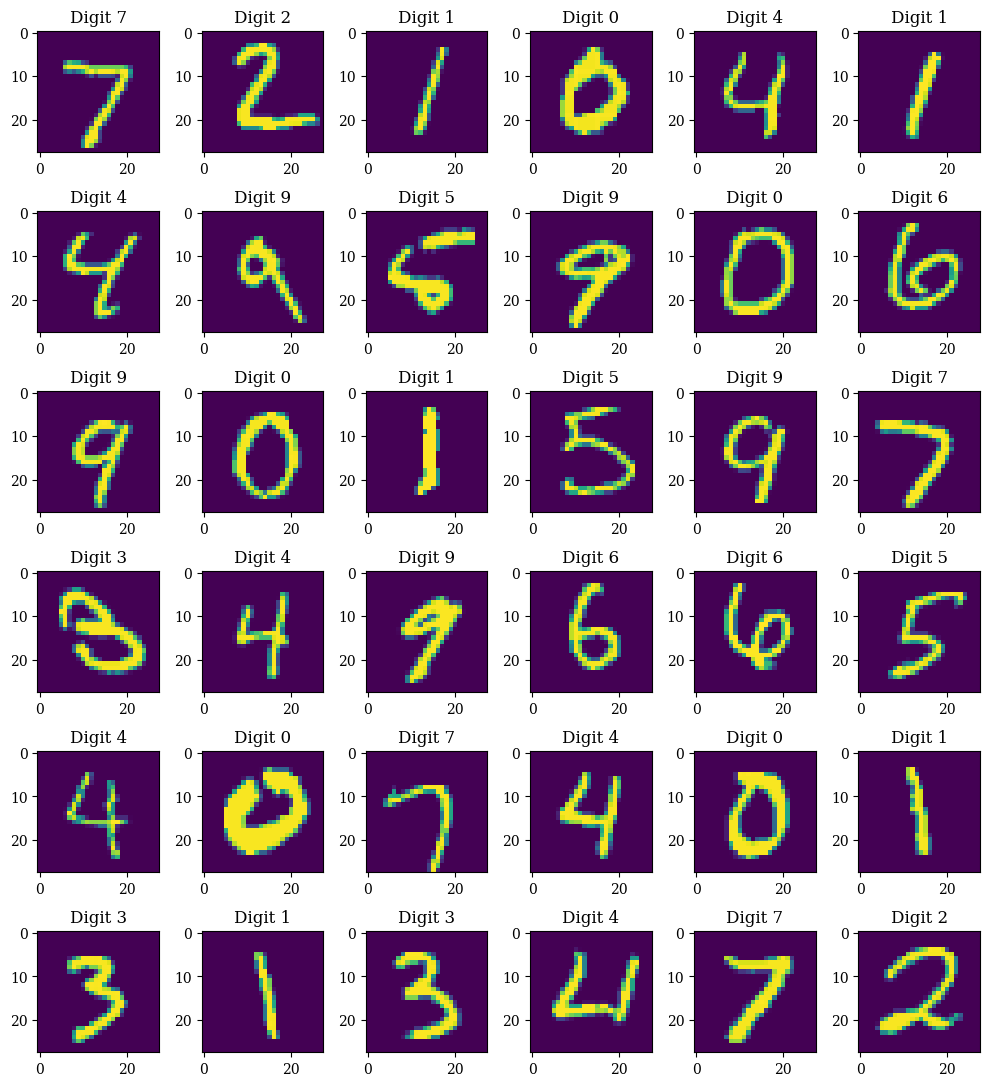

In [11]:
f = numpy.load(file="digits-labels.npz")

digits = f['d']     # [vec(digit) x # of digits]    [(28x28) x 10000] 
labels = f['l']     # [# of digits]                 [10000]           

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(6, 6, figsize=(10, 15))
matplotlib.pyplot.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.0, hspace=-0.75)

idx = 0
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(X=numpy.reshape(a=digits[:, idx], newshape=(28, 28), order='F'))
        axs[i, j].set_title(rf"Digit %s" % str(labels[idx]))
        idx += 1

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

##### PCA

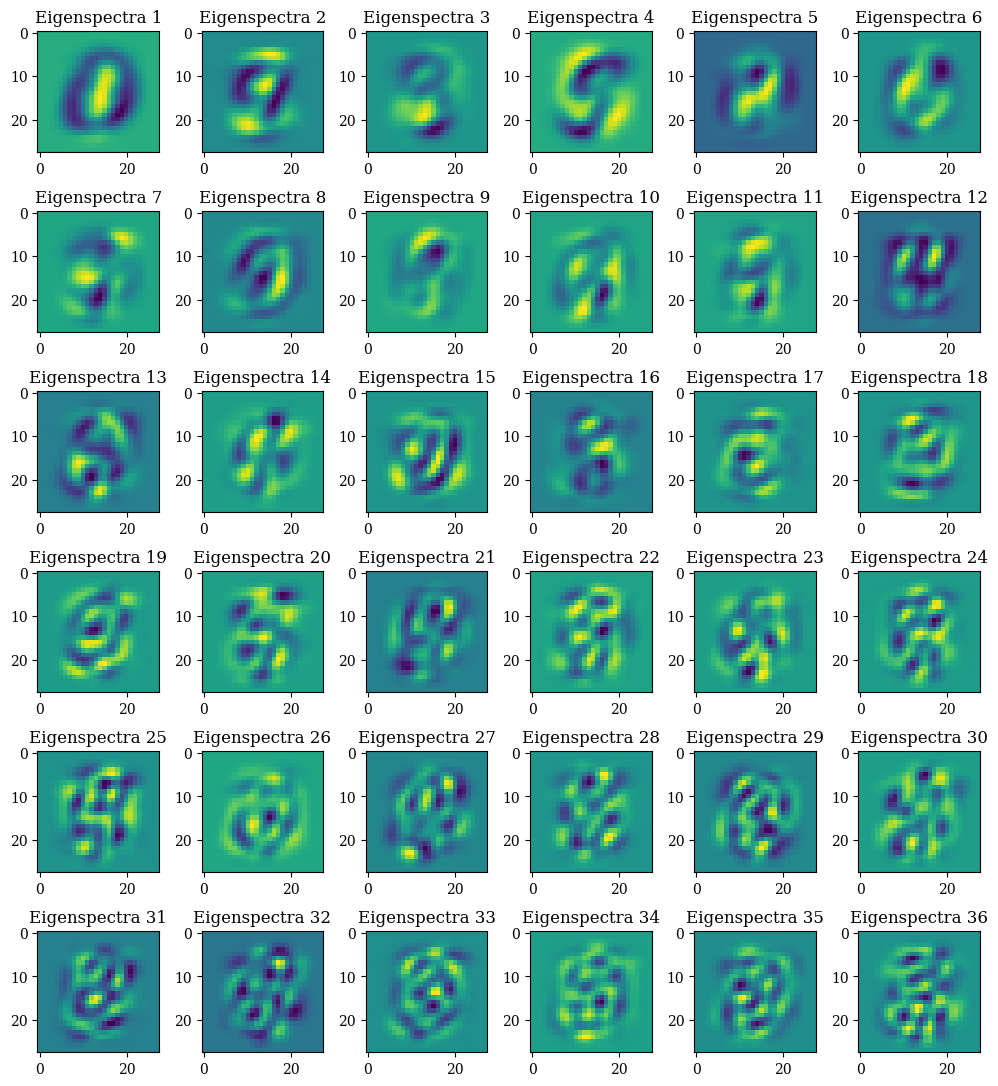

In [12]:
pca = PCA(num_components=36)
W_pca, Y_pca = pca.fit_transform(X=digits)

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(6, 6, figsize=(10, 15))
matplotlib.pyplot.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.0, hspace=-0.75)

idx = 0
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(X=numpy.reshape(a=W_pca[idx], newshape=(28, 28), order='F'))
        axs[i, j].set_title(rf"Eigenspectra {idx+1}")
        idx += 1

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

##### ICA

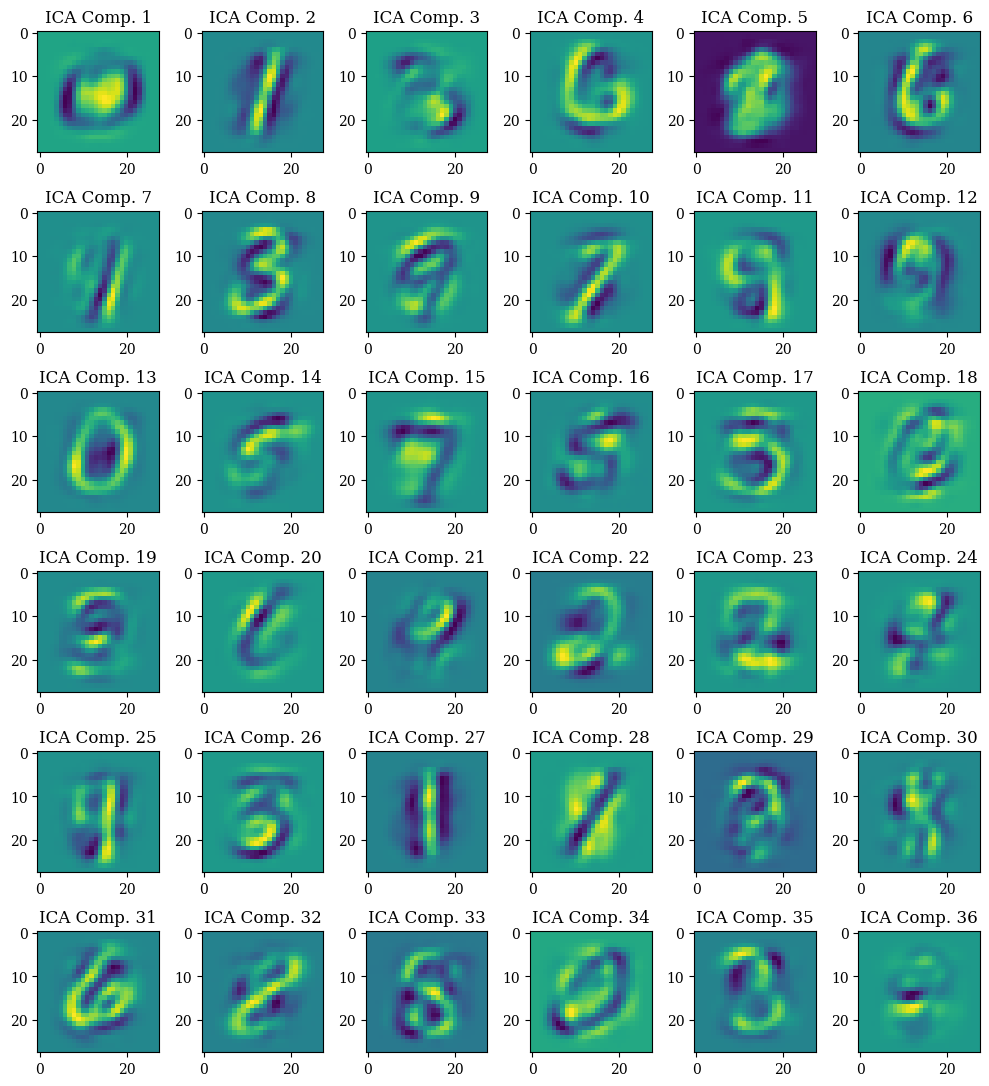

In [13]:
ica = ICA(num_components=36)
W_ica, Y_ica = ica.fit_transform(X=Y_pca, learning_rate=1e-5, tol=1e-1)
mixing_mat = scipy.linalg.pinv(a=W_ica@W_pca)

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(6, 6, figsize=(10, 15))
matplotlib.pyplot.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.0, hspace=-0.75)

idx = 0
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(X=numpy.reshape(a=mixing_mat[:, idx], newshape=(28, 28), order='F'))
        axs[i, j].set_title(rf"ICA Comp. {idx+1}")
        idx += 1

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

##### NMF


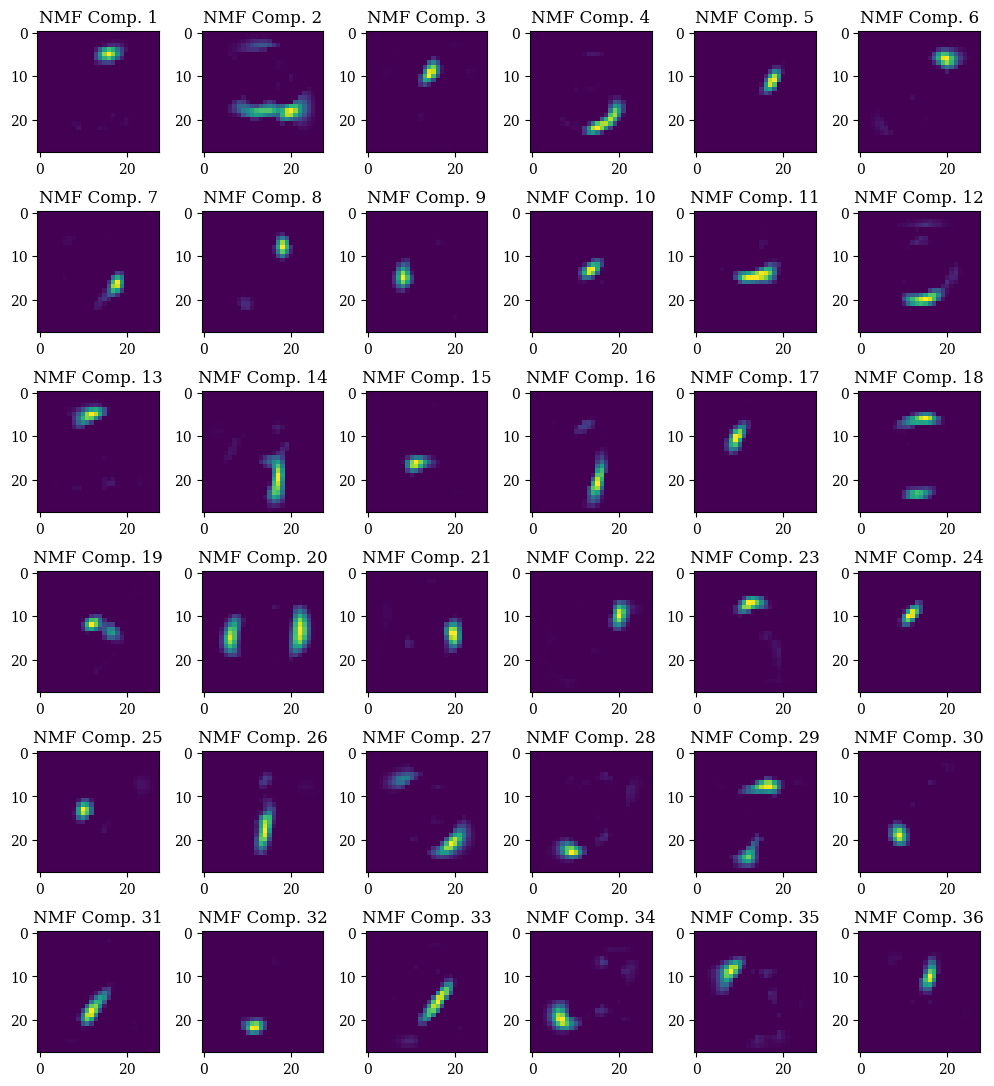

In [14]:
nmf = NMF(num_components=36)
W, H = nmf.fit_transform(X=digits)

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(6, 6, figsize=(10, 15))
matplotlib.pyplot.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.0, hspace=-0.75)

idx = 0
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(X=numpy.reshape(a=W[:, idx], newshape=(28, 28), order='F'))
        axs[i, j].set_title(rf"NMF Comp. {idx+1}")
        idx += 1

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

From $W_{pca}$, we can roughly see shapes of digits in the first few eigenvectors, but we cannot identify which digit it is. However, we cannot even identify the shape of the digits for the latter eigenvectors. It's because PCA assumes gaussian distribution of the data, and we can see from the second halves of the eigenvectors. They look like a mix of digit 0 to 9. For $W_{ica}W_{pca}$, we can clearly identify which digit it represents because ICA aims to separate information by transforming the input space into a maximally independent basis. Finally, for NMF, we can only observe some edges of a digit which is not really interpretable. However, it makes sense because they correctly represent the common key features of all digits instead of one single digit.

### Problem 3. The geometry of handwritten digits

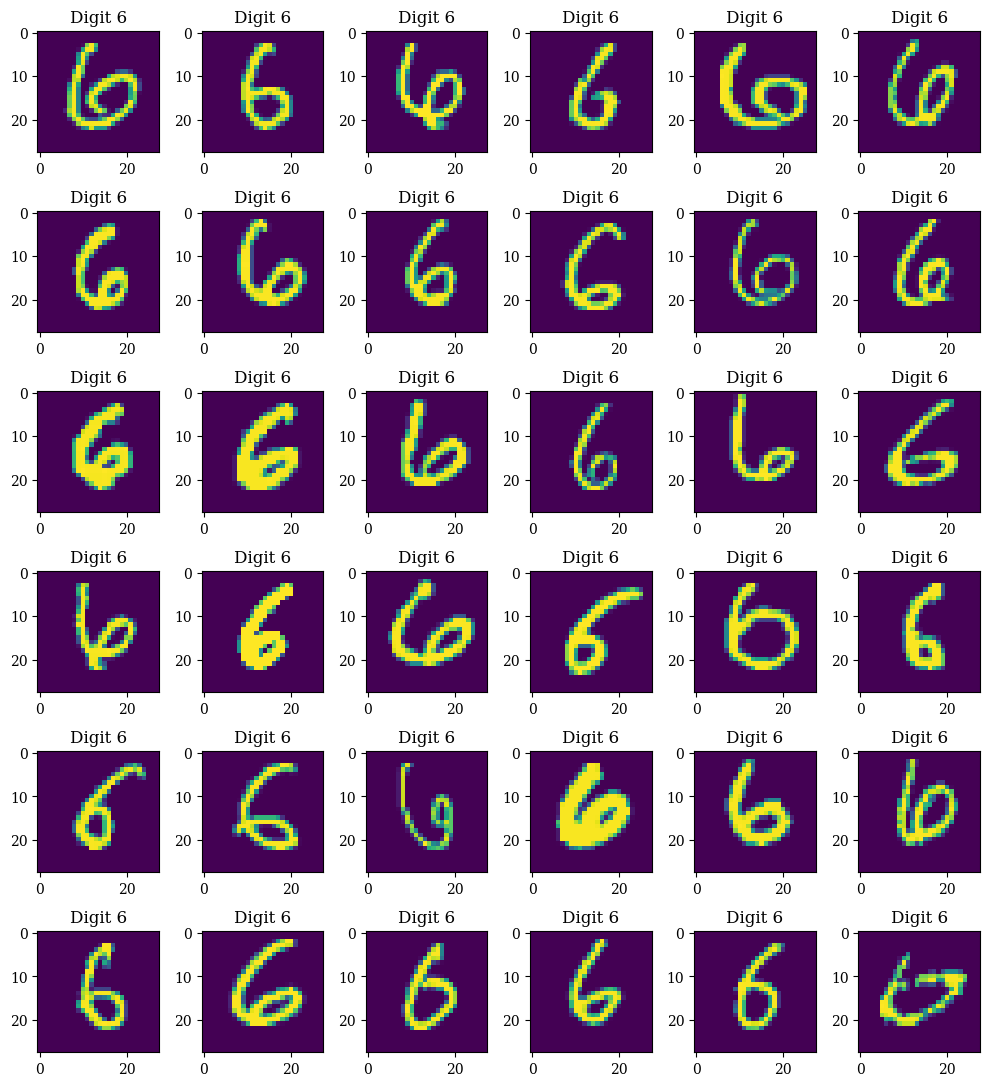

In [15]:
digits_6 = digits[:, labels==6]

matplotlib.pyplot.rc('font', family='serif')
fig, axs = matplotlib.pyplot.subplots(6, 6, figsize=(10, 15))
matplotlib.pyplot.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.0, hspace=-0.75)

idx = 0
for i in range(6):
    for j in range(6):
        axs[i, j].imshow(X=numpy.reshape(a=digits_6[:, idx], newshape=(28, 28), order='F'))
        axs[i, j].set_title(rf"Digit 6")
        idx += 1

matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

##### PCA

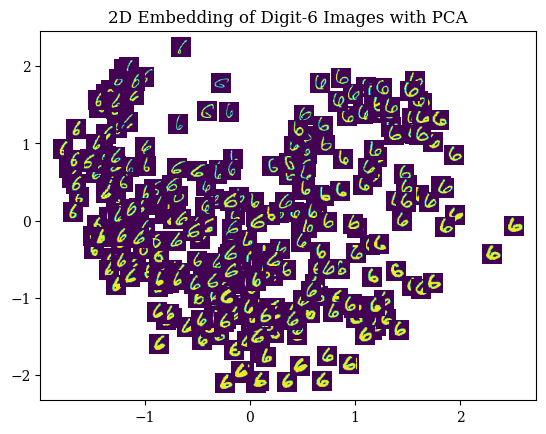

In [16]:
pca = PCA(num_components=2)
W_pca, Y_pca = pca.fit_transform(X=digits_6)

matplotlib.pyplot.rc('font', family='serif')
ax = matplotlib.pyplot.gca()
ax.set_title(rf"2D Embedding of Digit-6 Images with PCA")

for i in range(0, digits_6.shape[1], 3):
    img = PIL.Image.fromarray(obj=numpy.reshape(a=digits_6[:, i], newshape=(28, 28), order='F'))
    imScatter(ax=ax, img=img, x=Y_pca[0, i], y=Y_pca[1, i], zoom=0.5)

matplotlib.pyplot.show()

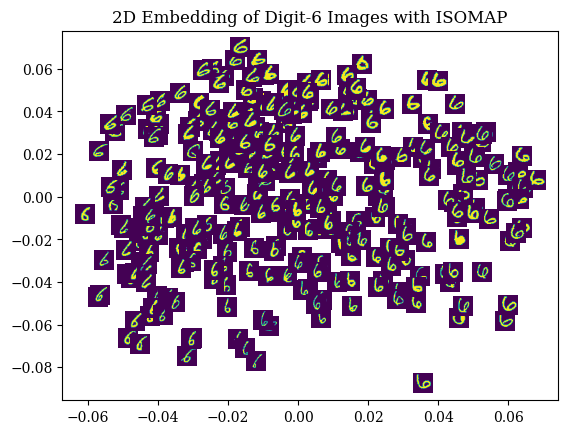

In [17]:
isomap = Isomap(num_nbrs=6, num_components=2)
Y_isomap = isomap.fit_transform(X=digits_6)

matplotlib.pyplot.rc('font', family='serif')
ax = matplotlib.pyplot.gca()
ax.set_title(rf"2D Embedding of Digit-6 Images with ISOMAP")

for i in range(0, digits_6.shape[1], 3):
    img = PIL.Image.fromarray(obj=numpy.reshape(a=digits_6[:, i], newshape=(28, 28), order='F'))
    imScatter(ax=ax, img=img, x=Y_isomap[0, i], y=Y_isomap[1, i], zoom=0.5)

matplotlib.pyplot.show()

The PCA result places all the digit $6$ with thick stroke at the bottom and ones with light stroke on the top. The entire orientation looks like a U shape. The result from ISOMAP tends to do the reverse, placing all the digit $6$ with thick stroke at the top and ones with light stroke at the bottom. Additionally, the results from ISOMAP spreads out the digits more evenly compared to PCA. It's because PCA tries to describe the data with a linear 1-dimensional manifold, which is simply a line, however Isomap is looking for a nonlinear (i.e. curved) 1-dimensional manifold.